#### Binary Classification of MAIT/iNKT Cells
Classify cell type (MAIT/iNKT) of a given CDR3 sequence using different machine/deep learning models and compare the results.
The input CDR3 sequences are either embedded using CVC or converted to one-hot encoding.

In [1]:
cd ..

/home/romi/projects/cvc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import collections
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import lab_notebooks.utils
import torch

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from lab_notebooks.utils import SC_TRANSFORMER, TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

In [4]:
DEVICE

device(type='cuda', index=0)

#### Load Data

In [53]:
# to load the embeddings from csv
load_csv = True

In [20]:
# load data, make sure to have V/J Gene of CDR3 sequence - below the data came from different datasets
# https:/ls e/www.10xgenomics.com/resources/datasets/nsclc-tumor-tcr-enrichment-from-amplified-c-dna-1-standard-2-2-0
data_dir_1 = DATA_DIR + "10x_nsclc_tra_trb_df.csv"
# https://www.10xgenomics.com/resources/datasets/20-k-bone-marrow-mononuclear-cells-bmmn-cs-5-ht-v-2-0-2-high-6-1-0
data_dir_2 = DATA_DIR + "20k_BMMNC_vdj_t_filtered_contig_annotations.csv"
# https://www.10xgenomics.com/resources/datasets/pbm-cs-of-a-healthy-donor-tcr-enrichment-from-amplified-c-dna-1-standard-3-0-0
data_dir_3 = DATA_DIR + "pbmc2_t_filtered_contig_annotations.csv"
# https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-5-v-2-0-chromium-x-2-standard-6-1-0
data_dir_4 = DATA_DIR + "10k_pbmc_vdj_t_filtered_contig_annotations.csv"
# https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-1-1-standard-3-0-2
data_dir_5 = DATA_DIR + "cd8_t_filtered_contig_annotations_d1.csv"
# https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-2-1-standard-3-0-2
data_dir_6 = DATA_DIR + "cd8_t_filtered_contig_annotations_d2.csv"
# https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-3-1-standard-3-0-2
data_dir_7 = DATA_DIR + "cd8_t_filtered_contig_annotations_d3.csv"
# https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-4-1-standard-3-0-2
data_dir_8 = DATA_DIR + "cd8_t_filtered_contig_annotations_d4.csv"

In [21]:
def sc_load_data(data_dir):
    sc_data = pd.read_csv(data_dir, usecols=["barcode", "contig_id", "chain", "v_gene", "j_gene", "c_gene", "cdr3", "cdr3_nt"], engine="pyarrow")
    sc_data = sc_data[sc_data.cdr3 != "None"]
    return sc_data

In [22]:
# read data
sc_data_1 = sc_load_data(data_dir_1)
sc_data_2 = sc_load_data(data_dir_2)
sc_data_3 = sc_load_data(data_dir_3)
sc_data_4 = sc_load_data(data_dir_4)
sc_data_5 = sc_load_data(data_dir_5)
sc_data_6 = sc_load_data(data_dir_6)
sc_data_7 = sc_load_data(data_dir_7)
sc_data_8 = sc_load_data(data_dir_8)

In [23]:
len(sc_data_1), len(sc_data_2), len(sc_data_3), len(sc_data_4), len(sc_data_5), len(sc_data_6), len(sc_data_7), len(sc_data_8)

(3643, 19737, 6037, 14632, 123862, 191643, 321467, 233142)

#### Preprocess Data - Label MAIT/iNKT Cells

In [24]:
MAIT_v_gene='TRAV1-2'
MAIT_j_gene = ['TRAJ33', 'TRAJ20', 'TRAJ12']
iNKT_v_gene = 'TRAV10'
iNKT_j_gene = 'TRAJ18'

v_gene_to_use = MAIT_v_gene #iNKT_v_gene
j_gene_to_use = MAIT_j_gene #iNKT_j_gene
cell_label_to_use = 'MAIT_cell'#'iNKT_cell'

In [25]:
def label_iNKT_MAIT(sc_df, v_gene_list, j_gene_list, cell_label):
    cell_label_not = 'non-'+cell_label
    sc_df_tra = sc_df[sc_df['chain'] == 'TRA']

    # create "MAIT_cell" column if the v_gene is "TRAV1-2" and j_gene is TRAJ33 or TRAJ20 or TRAJ12
    sc_df_tra[cell_label] = np.where((sc_df_tra['v_gene'] == v_gene_list) &
                                     (sc_df_tra['j_gene'].str.contains('|'.join(j_gene_list))), cell_label, cell_label_not)

    # extract the list of barcodes from the dataframe that are MAIT cells
    true_label_barcodes = sc_df_tra[sc_df_tra[cell_label] == cell_label]['barcode'].tolist()

    # create a column in embed_data that is MAIT_cell if the barcode is in the MAIT_barcodes list, and non-MAIT_cell otherwise
    sc_df[cell_label] = np.where(sc_df['barcode'].isin(true_label_barcodes), cell_label, cell_label_not)
    return sc_df

In [31]:
sc_data_1_labeled = label_iNKT_MAIT(sc_data_1, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_2_labeled = label_iNKT_MAIT(sc_data_2, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_3_labeled = label_iNKT_MAIT(sc_data_3, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_4_labeled = label_iNKT_MAIT(sc_data_4, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_5_labeled = label_iNKT_MAIT(sc_data_5, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_6_labeled = label_iNKT_MAIT(sc_data_6, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_7_labeled = label_iNKT_MAIT(sc_data_7, v_gene_to_use, j_gene_to_use, cell_label_to_use)
sc_data_8_labeled = label_iNKT_MAIT(sc_data_8, v_gene_to_use, j_gene_to_use, cell_label_to_use)

/tmp/ipykernel_5483/2974906851.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_df_tra[cell_label] = np.where((sc_df_tra['v_gene'] == v_gene_list) &
/tmp/ipykernel_5483/2974906851.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_df_tra[cell_label] = np.where((sc_df_tra['v_gene'] == v_gene_list) &
/tmp/ipykernel_5483/2974906851.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [32]:
# take only TRB chains
sc_data_1_labeled_TRB = sc_data_1_labeled[sc_data_1_labeled.chain == 'TRB']
sc_data_2_labeled_TRB = sc_data_2_labeled[sc_data_2_labeled.chain == 'TRB']
sc_data_3_labeled_TRB = sc_data_3_labeled[sc_data_3_labeled.chain == 'TRB']
sc_data_4_labeled_TRB = sc_data_4_labeled[sc_data_4_labeled.chain == 'TRB']
sc_data_5_labeled_TRB = sc_data_5_labeled[sc_data_5_labeled.chain == 'TRB']
sc_data_6_labeled_TRB = sc_data_6_labeled[sc_data_6_labeled.chain == 'TRB']
sc_data_7_labeled_TRB = sc_data_7_labeled[sc_data_7_labeled.chain == 'TRB']
sc_data_8_labeled_TRB = sc_data_8_labeled[sc_data_8_labeled.chain == 'TRB']
sc_data_all_labeled_TRB = pd.concat([sc_data_1_labeled_TRB, sc_data_2_labeled_TRB, sc_data_3_labeled_TRB, sc_data_4_labeled_TRB, sc_data_5_labeled_TRB, sc_data_6_labeled_TRB, sc_data_7_labeled_TRB, sc_data_8_labeled_TRB])

In [33]:
collections.Counter(sc_data_all_labeled_TRB[cell_label_to_use])

Counter({'non-MAIT_cell': 520358, 'MAIT_cell': 6493})

In [34]:
# drop duplicates
sc_data_all_labeled_TRB = sc_data_all_labeled_TRB.drop_duplicates(subset=['cdr3'])
# drop nan
sc_data_all_labeled_TRB = sc_data_all_labeled_TRB.dropna(subset=['cdr3'])

In [35]:
collections.Counter(sc_data_all_labeled_TRB[cell_label_to_use])

Counter({'non-MAIT_cell': 122189, 'MAIT_cell': 2508})

In [36]:
# export data
sc_data_all_labeled_TRB.to_csv('./CDR3_data/sc_data_MAIT_TRB_8_datasets.csv', index=False)

#### Split cell-types into equal groups

In [37]:
cell_label = cell_label_to_use
cell_label_not = 'non-'+cell_label

In [38]:
cell_count = collections.Counter(sc_data_all_labeled_TRB[cell_label])[cell_label]
NUM_TO_SAMPLE = cell_count
# sample equal number of private and public
if cell_label == 'MAIT_cell':
    true_sample = sc_data_all_labeled_TRB.query('MAIT_cell == "MAIT_cell"').sample(NUM_TO_SAMPLE)
    false_sample = sc_data_all_labeled_TRB.query('MAIT_cell == "non-MAIT_cell"').sample(NUM_TO_SAMPLE)
else:
    true_sample = sc_data_all_labeled_TRB.query('iNKT_cell == "iNKT_cell"').sample(NUM_TO_SAMPLE)
    false_sample = sc_data_all_labeled_TRB.query('iNKT_cell == "non-iNKT_cell"').sample(NUM_TO_SAMPLE)

In [39]:
# join public and private samples
cell_type_data_sample = pd.concat([true_sample, false_sample])
cell_type_data_sample

,barcode,contig_id,chain,v_gene,j_gene,c_gene,cdr3,cdr3_nt,MAIT_cell
64350,GGAACTTGTCTGCGGT-5,GGAACTTGTCTGCGGT-5_contig_4,TRB,TRBV7-9,TRBJ2-7,TRBC2,CASSVAGLLYEQYF,TGTGCCAGCAGCGTCGCGGGACTCCTTTACGAGCAGTACTTC,MAIT_cell
20087,ACCGTAAGTACACCGC-34,ACCGTAAGTACACCGC-34_contig_1,TRB,TRBV4-2,TRBJ1-5,TRBC1,CASSHPPGADLGGQPQHF,TGTGCCAGCAGCCACCCCCCGGGAGCGGATCTGGGGGGTCAGCCCC...,MAIT_cell
9572,AAGCCGCAGTAGTGCG-20,AAGCCGCAGTAGTGCG-20_contig_2,TRB,TRBV30,TRBJ1-5,TRBC1,CAWSVPPVQGDRTQHF,TGTGCCTGGAGTGTACCCCCCGTCCAGGGGGATCGGACCCAGCATTTT,MAIT_cell
37069,AGATCTGGTTGGTTTG-9,AGATCTGGTTGGTTTG-9_contig_2,TRB,TRBV20-1,TRBJ1-2,TRBC1,CSARDLDSLTNGYTF,TGCAGTGCTAGAGATCTGGACAGCCTTACGAATGGCTACACCTTC,MAIT_cell
11894,GCATGATAGGCCGAAT-1,GCATGATAGGCCGAAT-1_contig_2,TRB,TRBV30,TRBJ2-3,TRBC2,CAWSGEPSQAQYF,TGTGCCTGGAGTGGGGAACCTAGCCAGGCGCAGTATTTT,MAIT_cell
...,...,...,...,...,...,...,...,...,...
33865,ATCGAGTTCATGTAGC-3,ATCGAGTTCATGTAGC-3_contig_4,TRB,TRBV6-1,TRBJ1-6,TRBC1,CASTGENNSPLHF,TGTGCCAGCACTGGCGAAAATAATTCACCCCTCCACTTT,non-MAIT_cell
51019,CATCCACGTTCCGTCT-35,CATCCACGTTCCGTCT-35_contig_1,TRB,TRBV9,TRBJ2-2,TRBC2,CASSVDWSGPGNTGELFF,TGTGCCAGCAGCGTAGATTGGTCAGGGCCAGGGAACACCGGGGAGC...,non-MAIT_cell
115496,TCCCGATCATGATCCA-2,TCCCGATCATGATCCA-2_contig_3,TRB,TRBV20-1,TRBJ2-1,TRBC2,CSARALAGGTNEQFF,TGCAGTGCTAGAGCTCTAGCGGGGGGGACAAATGAGCAGTTCTTC,non-MAIT_cell
57339,CCGGGATGTAGCACGA-37,CCGGGATGTAGCACGA-37_contig_2,TRB,TRBV28,TRBJ1-5,TRBC1,CASSFQGGDQPQHF,TGTGCCAGCAGTTTTCAAGGAGGAGATCAGCCCCAGCATTTT,non-MAIT_cell


In [40]:
# convert label column to numpy array
cell_label_array = cell_type_data_sample[cell_label].to_numpy()
print(cell_label_array)

['MAIT_cell' 'MAIT_cell' 'MAIT_cell' ... 'non-MAIT_cell' 'non-MAIT_cell'
 'non-MAIT_cell']


In [43]:
# rename cdr3 column to Sequences for embedding creation
cell_type_data_sample.rename(columns={"cdr3": "Sequences"}, inplace=True)

In [44]:
from cvc.embbeding_wrapper import EmbeddingWrapper
# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, sequences_df=cell_type_data_sample, batch_size=256, method="mean", layers=[-1], pbar=True, max_len=64)
embed_wrap.embeddings.shape

Some weights of the model checkpoint at /home/romi/projects/cvc/output_5mil_even_priv_pub were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/20 [00:00<?, ?it/s]

(5016, 768)

In [45]:
# create anndata object
embeddings_adata = embed_wrap.create_anndata()
# embeddings df
df_embeddings = pd.DataFrame(embed_wrap.embeddings)

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [46]:
# add MAIT label to dataframe
df_embeddings_with_label = df_embeddings
df_embeddings_with_label[cell_label]=list(embeddings_adata.obs[cell_label])
df_embeddings_with_label['Sequences']=list(embeddings_adata.obs['Sequences'])

In [47]:
file_embedding_path = './' + cell_label + '_data_embeddings_8_datasets.csv'
# export embeddings to csvֿ
df_embeddings_with_label.to_csv(DATA_DIR + file_embedding_path)

In [63]:
# load from csv
if load_csv==True:
    df_embeddings_with_label = pd.read_csv("./CDR3_data/MAIT_cell_data_embeddings_8_datasets.csv")
    df_embeddings_with_label = df_embeddings_with_label.drop_duplicates(subset=['Sequences'])
    # remove Public_Private_Label column
    # df_embeddings_with_label = df_embeddings_with_label.drop(columns=['Public_Private_Label'])
cell_type_embeddings = df_embeddings_with_label.iloc[:,1:-2].to_numpy()
cell_type_label_array= df_embeddings_with_label.MAIT_cell.to_numpy()

In [65]:
# drop duplicates Sequences
df_embeddings_with_label = df_embeddings_with_label.drop_duplicates(subset=['Sequences'])
collections.Counter(df_embeddings_with_label.MAIT_cell)

Counter({'MAIT_cell': 2508, 'non-MAIT_cell': 2508})

#### Binary Classification Utils

In [66]:
TRAIN_RATIO = 0.8

def split_train_test(embeddings, embedding_labels):
    #import pdb; pdb.set_trace()
    # The data will be divided into 80% training 20% validation
    idx_train = int(len(embeddings) * TRAIN_RATIO)

    indices = np.arange(embeddings.shape[0])

    # Shuffle data
    np.random.shuffle(indices)

    # Separate the images and the labels
    embeddings_shuffle = embeddings[indices] 
    embedding_labels_shuffle = embedding_labels[indices]

    # Split to train and validation
    train_embeddings = embeddings_shuffle[:idx_train]
    train_labels = embedding_labels_shuffle[:idx_train]
    validation_embeddings = embeddings_shuffle[idx_train:]
    validation_labels = embedding_labels_shuffle[idx_train:]
    
    return train_embeddings, train_labels, validation_embeddings, validation_labels

In [67]:
embeddings = cell_type_embeddings
embedding_labels = cell_type_label_array
print("shape of embeddings: {}\nshape of embedding_labels: {}".format(embeddings.shape,embedding_labels.shape))

shape of embeddings: (5016, 768)
shape of embedding_labels: (5016,)


In [68]:
train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels = split_train_test(embeddings, embedding_labels)
train_embeddings.shape, embed_train_labels.shape, validation_embeddings.shape, embed_validation_labels.shape

((4012, 768), (4012,), (1004, 768), (1004,))

In [69]:
labels = [cell_label, cell_label_not]
label_to_id = {label: i for i, label in enumerate(labels)}
numeric_train_labels = [label_to_id[label] for label in embed_train_labels]
numeric_valid_labels = [label_to_id[label] for label in embed_validation_labels]

In [70]:
# check that the data is even
collections.Counter(numeric_valid_labels), collections.Counter(numeric_train_labels)

(Counter({1: 524, 0: 480}), Counter({0: 2028, 1: 1984}))

##### One-Hot Encoding

In [61]:
# Import Dependencies 
import pandas as pd
import numpy as np
import torch.nn.functional as F

# Function to encode sequences
def encode_seq(sequence, max_cdr3_len):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', "*"]
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    
    # one hot encode
    integer_encoded = torch.tensor(integer_encoded)
    integer_encoded = F.one_hot(integer_encoded, num_classes=len(alphabet))
    
    # pad integer_encoded tensor first dim with zeros up to max_cdr3_len
    integer_encoded = F.pad(integer_encoded, (0,0,0, max_cdr3_len - len(integer_encoded)))
    
    integer_encoded = integer_encoded.numpy()

    return integer_encoded

In [62]:
# extract sequences
cdr3_sequences = df_embeddings_with_label['Sequences']#tcrb_data_sample['Sequences']
sequences_labels = cell_type_label_array
max_cdr3_len = cdr3_sequences.apply(len).max()
max_cdr3_len

22

In [63]:
# split data into train/test
train_seqs, train_labels, validation_seqs, validation_labels = split_train_test(cdr3_sequences.to_numpy(), sequences_labels)
print("shape of training set: {}\nshape of validation set: {}".format(train_seqs.shape, validation_seqs.shape))

shape of training set: (876,)
shape of validation set: (220,)


In [64]:
numeric_train_onehot_labels = [label_to_id[label] for label in train_labels]
numeric_valid_onehot_labels = [label_to_id[label] for label in validation_labels]

In [65]:
# encode amino acid sequences to one hot vector
encoded_train_seqs = pd.Series(train_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))
encoded_validation_seqs = pd.Series(validation_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))

In [66]:
# Stack list(encoded_train_seqs) in dim 0
train_seqs_stack = np.stack(encoded_train_seqs, axis=0)
valid_seqs_stack = np.stack(encoded_validation_seqs, axis=0)
train_seqs_stack.shape, valid_seqs_stack.shape

((876, 22, 21), (220, 22, 21))

In [67]:
# reshape train/validation tensors
train_seqs_stack = train_seqs_stack.reshape(train_seqs_stack.shape[0], -1)
valid_seqs_stack = valid_seqs_stack.reshape(valid_seqs_stack.shape[0], -1)
train_seqs_stack.shape, valid_seqs_stack.shape

((876, 462), (220, 462))

#### xgBoost on Embeddings
Guide on xgBoost - https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

In [ ]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_embeddings = sc.fit_transform(train_embeddings)
validation_embeddings = sc.fit_transform(validation_embeddings)

In [ ]:
# extract accuracy
accuracy_xgb, xgb_preds, xgb_classifier = \
    lab_notebooks.utils.xgb_classify(train_embeddings, numeric_train_labels, validation_embeddings, numeric_valid_labels)
accuracy_xgb

In [ ]:
# plot the roc curve for the model
# get probabilities
probs = xgb_classifier.predict_proba(validation_embeddings)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(numeric_valid_labels, probs[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#### xgBoost on One-Hot Encoding

In [54]:
# apply xgb on onehot, extract accuracy
accuracy_xgb_onehot, xgb_preds_onehot, xgb_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, numeric_train_onehot_labels, valid_seqs_stack, numeric_valid_onehot_labels)

# get probabilities and roc
probs = xgb_classifier_onehot.predict_proba(valid_seqs_stack)
fpr_onehot_xgb, tpr_onehot_xgb, thresholds_onehot_xgb = roc_curve(numeric_valid_onehot_labels, probs[:, 1])
roc_auc_onehot_xgb = auc(fpr_onehot_xgb, tpr_onehot_xgb)

accuracy_xgb_onehot

77.27272727272727

#### LDA

In [51]:
# apply LDA
accuracy_lda, lda_preds, lda_classifier = lab_notebooks.utils.lda_classify(train_embeddings,numeric_train_labels, validation_embeddings, numeric_valid_labels)

In [52]:
# plot the roc curve for the model
# get probabilities
probs = lda_classifier.predict_proba(validation_embeddings)
fpr_lda, tpr_lda, thresholds_lda = roc_curve(numeric_valid_labels, probs[:, 1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

accuracy_lda

60.0

#### LDA oneHot

In [53]:
accuracy_lda_onehot, lda_preds_onehot, lda_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, numeric_train_onehot_labels, valid_seqs_stack, numeric_valid_onehot_labels)

probs_oh_lda = lda_classifier_onehot.predict_proba(valid_seqs_stack)
fpr_onehot_lda, tpr_onehot_lda, thresholds_onehot_lda = roc_curve(numeric_valid_onehot_labels, probs_oh_lda[:, 1])
roc_auc_onehot_lda = auc(fpr_onehot_lda, tpr_onehot_lda)

accuracy_lda_onehot

77.27272727272727

### Deep Neural Network

#### Deep Learning Model on Embeddings

In [80]:
# set flag to run with onehot
DNN_ONEHOT = 0

In [81]:
# defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x, y):
        # self.x = torch.tensor(x, dtype=torch.float32).to('cuda')
        # self.y = torch.tensor(y, dtype=torch.float32).to('cuda')
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
        assert self.x.shape[0] == self.y.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length

In [82]:
BATCH_SIZE = 32

# create datasets
if DNN_ONEHOT==0:
    trainset = dataset(train_embeddings, numeric_train_labels)
    validset = dataset(validation_embeddings, numeric_valid_labels)
else:
    trainset = dataset(train_seqs_stack, numeric_train_onehot_labels)
    validset = dataset(valid_seqs_stack, numeric_valid_onehot_labels)

# DataLoader with 10 workers
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True)

In [83]:
# defining the network
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,128)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,1)
    
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [84]:
# hyper parameters
learning_rate = 0.00001

# set input shape
input_shape = train_embeddings.shape[1]
if DNN_ONEHOT:
    input_shape = train_seqs_stack.shape[1]

# Model , Optimizer, Loss
device = 'cpu'
model = Net(input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [85]:
def calculate_accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    y_test = y_test.unsqueeze(1)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [86]:
def train_classify(model, trainloader, optimizer):
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.train()
    for train_embedding, train_label in tqdm.notebook.tqdm(trainloader, total=len(trainloader)):
        # option to move train_embedding, train_label to gpu here
        # calculate output
        train_embedding, train_label =  train_embedding.to(device), train_label.to(device)
        output = model(train_embedding)
        
        # calculate loss
        loss = loss_fn(output, train_label.reshape(-1,1))
        
        # accuracy
        acc = calculate_accuracy(output, train_label)
        
        # backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        count += len(train_label)
        
    return epoch_loss / len(trainloader), epoch_acc / len(trainloader)

In [87]:
def evaluate_classify(model, validloader): 
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.eval()
    label_list = []
    pred_label_list = []
    with torch.no_grad(): 
        for valid_embedding, valid_label in tqdm.notebook.tqdm(validloader, total=len(validloader)):
            # option to move valid_embedding, valid_label to gpu here
            valid_embedding, valid_label = valid_embedding.to(device), valid_label.to(device)
            # calculate output
            output = model(valid_embedding)

            # calculate loss
            loss = loss_fn(output, valid_label.reshape(-1,1))

            # accuracy
            acc = calculate_accuracy(output, valid_label)
            
            # add to lists for confusion matrixv
            label_list.append(valid_label.cpu())
            pred_label_list.append(output.cpu())
            
            #acc = calculate_accuracy(output, valid_label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count += len(valid_label)
    return (epoch_loss / len(validloader), epoch_acc / len(validloader),
            torch.cat(label_list, dim=0), 
            torch.cat(pred_label_list, dim=0))

In [ ]:
from livelossplot import PlotLosses

liveloss1_class = PlotLosses()
logs_class = {}
EPOCHS=150

for epoch in range(EPOCHS):
    print('starting epoch {}'.format(epoch))
    train_loss, train_acc = train_classify(model, trainloader, optimizer)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, EPOCHS, train_loss))
    
    print('Epoch {} of {}, Train Accuracy: {:.3f}'.format(
          epoch+1, EPOCHS, train_acc))
    
    logs_class['train loss'] = train_loss
    logs_class['train accuracy'] = train_acc

    valid_loss, valid_acc, label_list, pred_label_list  = evaluate_classify(model, validloader)
    print('Epoch {} of {}, Validate Loss: {:.3f}'.format(
        epoch+1, EPOCHS, valid_loss))
    
    print('Epoch {} of {}, Validate Accuracy: {:.3f}'.format(
        epoch+1, EPOCHS, valid_acc))

    logs_class['validation loss'] = valid_loss
    logs_class['validation accuracy'] = valid_acc
        
    liveloss1_class.update(logs_class)
    liveloss1_class.send()

In [78]:
# Save model
PATH = "./classifiers/MAIT_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, PATH)

In [ ]:
# get predictions from model
label_list = []
pred_label_list = []
_, _, label_list, pred_label_list = evaluate_classify(model, validloader)

In [ ]:
preds, labels = pred_label_list[:, 0].cpu().numpy(), label_list.unsqueeze(1)[:, 0].cpu().numpy()
preds_at_threshold_05 = (preds > 0.5).astype(int)
labels = labels.astype(int)

In [ ]:
# calculate FN, TP, TN, FP 
tn_nn, fp_nn, fn_nn, tp_nn = confusion_matrix(preds_at_threshold_05, labels).ravel()

labels_vals = [tn_nn, fp_nn, fn_nn, tp_nn]
labels_TF = [f"True Negative","False Positive","False Negative","True Positive"]
sum_all = tn_nn + fp_nn + fn_nn + tp_nn

labels_vals_str = [str(round(val/sum_all, 4)*100) for val in labels_vals]
labels_TF_final = [f"{label}\n{label_val_str}%" for label, label_val_str in zip(labels_TF, labels_vals_str)]

In [ ]:
labels_TF_final = [[labels_TF_final[0], labels_TF_final[1]], [labels_TF_final[2], labels_TF_final[3]]]

In [ ]:
# calculate confusion matrix
confusion_mat_val = confusion_matrix(preds_at_threshold_05, label_list.cpu().numpy())
labels_TF = np.asarray(labels_TF).reshape(2,2)
plt.figure(figsize = (10,7))
sns.heatmap(confusion_mat_val, annot=labels_TF_final, fmt="", cmap='RdPu')

In [ ]:
# roc data for DNN
if DNN_ONEHOT==0:
    fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(embed_validation_labels, preds)
    roc_auc_dnn = auc(fpr_dnn, tpr_dnn)
else:
    fpr_onehot_dnn, tpr_onehot_dnn, thresholds_onehot_dnn = roc_curve(validation_labels, preds)
    roc_auc_onehot_dnn = auc(fpr_onehot_dnn, tpr_onehot_dnn)

#### Plot Results

In [81]:
dnn_dic_1 = {'DNN': [81.43, 78.857, 78.427],
             'DNN_OneHot': [71.429, 75.143, 79.7]}

# calculate mean accuracy for each model
res_dnn_avg = {key: np.mean(value) for key, value in dnn_dic_1.items()}
res_dnn_avg

{'DNN': 79.57133333333333, 'DNN_OneHot': 75.42399999999999}

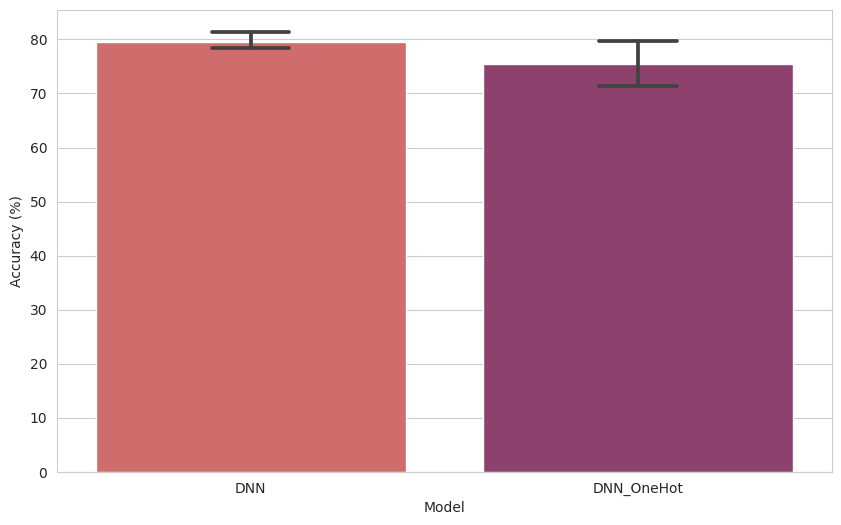

In [8]:
# dictionary
dnn_dic = {'model': ['DNN', 'DNN', 'DNN',
                     'DNN_OneHot', 'DNN_OneHot', 'DNN_OneHot'],
           'accuracy': [81.43, 78.857, 78.427, 71.429, 75.143, 79.7]}

# barplot of accuracy with error bars
df = pd.DataFrame(dnn_dic)
df = df.sort_values(by='accuracy', ascending=False)
df = df.reset_index(drop=True)
df
# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='model', y='accuracy', data=df, ax=ax, palette="flare", capsize=.2)
# ax.set_title('Accuracy of different classification models')
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model')
# ax.set_ylim(85, 100)
# save figure in svg format in high resolution
plt.savefig('./plots/cvc_2.0/accuracy_MAIT.svg', format='svg', dpi=1200)
plt.show()